# Analisis de series de tiempo

En este analisis crearemos una rutina para la descripcion, descomposicion y analisiz a profundidad de las series de tiempo de la red mpomm alojadas en la base de datos oficial.


## Obtencion de datos
---
### EVC-SOMO
1. Solicitud a la API **EVC-SOMO**

    Por medio de la **API-REST** creada para el manejo de los datos de la **RED MPOMM**, se ejecuta la solicitud de obtencion de la serei temporal de esta manera obtenemos los datos **oficiales** avalados por el area de **SOMO** del centro de investigaciones del pacifico.

In [1]:
# Solicitud de datos a la API REST
from api_somo import DataFetcher, fetch_qf 
import logging

# Setting up logging for the main script
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/filter-serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    #"start_date":"2009-01-01",
    #"end_date":"2023-12-31"
    }

try:
    # 1. Fetch and process the data
    red_mpomm_serie = DataFetcher.fetch_and_process_data(api_url, params)

    if red_mpomm_serie.empty:
        raise ValueError("The historical series is empty.")

    # Additional processing with the historical series
    logger.info(f"Fetched historical series: {red_mpomm_serie.head(0)}")

except Exception as e:
    logger.error(f"Error fetching historical series: {e}")


display(red_mpomm_serie.columns)
display(round(red_mpomm_serie.describe(),3))

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/filter-serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag', 'latitude', 'longitude']
INFO:api_somo:Columns after renaming: ['timestamp', 'value', 'qf', 'latitude', 'longitude']
INFO:api_somo:Timestamp conversion and indexing complete.
INFO:__main__:Fetched historical series: Empty DataFrame
Columns: [value, qf, latitude, longitude]
Index: []


Index(['value', 'qf', 'latitude', 'longitude'], dtype='object')

,value,qf,latitude,longitude
count,731807.000,731807.000,731807.00,731807.000
mean,-4052.049,1.324,1.82,-78.729
std,19717.745,1.578,0.00,0.000
min,-99999.000,1.000,1.82,-78.729
25%,0.000,1.000,1.82,-78.729
50%,0.000,1.000,1.82,-78.729
75%,0.000,1.000,1.82,-78.729
max,1464.000,9.000,1.82,-78.729


2. Preprocesamiento de los datos

    Manejo de datos con baja calidad

    Ya que la serie tiene una previa evaluacion de calidad, manejamos solo los datos que se consideran "buenos", convertimos a **NaN** los valores asociados a calidades distintas de *bueno(1)*.
    - Realizamos un reporte de la cantidad de NaN en la serie 
    - Verificamos sus estadisticas.

In [2]:
import numpy as np
import pandas as pd

red_mpomm_serie.index = pd.to_datetime(red_mpomm_serie.index).tz_localize(None)
red_mpomm_serie = red_mpomm_serie.rename(columns={'value': 'tumaco'})

red_mpomm_serie.loc[~red_mpomm_serie['qf'].isin([1, 3])] = np.nan
#red_mpomm_serie.drop(columns=['latitude','longitude'], inplace=True)
#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
print('Reporte de datos NaN por columna: ')
print(red_mpomm_serie.isnull().sum(),'\n')

serie = pd.Series(red_mpomm_serie.iloc[:, 0])  # Selecciona la primera columna
print('Reporte de estadistica de la serie temporal (value): ')
print(round(serie.describe(),3))

Reporte de datos NaN por columna: 
tumaco       29717
qf           29717
latitude     29717
longitude    29717
dtype: int64 

Reporte de estadistica de la serie temporal (value): 
count    702090.000
mean          0.049
std           0.503
min           0.000
25%           0.000
50%           0.000
75%           0.000
max          57.200
Name: tumaco, dtype: float64


- Remuestreo de la serie.

    En este punto se toman los valores del sensor y se convierten en **serie** , luego se aplica un remuestreo de la serie ya que la maxima resolucion que nos da chirps es diaria entonces debemos submuestrear esta serie para obtener una diaria, pero en la rutina vamos a incluir un umbral de calidad con el cual controlaremos hasta que porcentaje de nans podemos aceptar para tomar como valido el dato remuestreado.

    El porcentaje maximo permitido para este caso lo dejamos en 20%
    

In [3]:
# Remuestreo condicional

# Función para eliminar grupos con más de un porcentaje de NaN
def custom_resample(group, nan_threshold=0.2):
    nan_ratio = group.isna().sum() / len(group)
    return group.sum() if nan_ratio < nan_threshold else np.nan

# Resampleo con diferentes períodos de agregación
serie = serie.resample('D').apply(lambda g: custom_resample(g, nan_threshold=0.2))
print(f'Reporte de datos NaN y/o null en la serie actual con frecuencia {serie.index.inferred_freq}: ')
print(serie.isnull().sum(),'\n')


Reporte de datos NaN y/o null en la serie actual con frecuencia D: 
269 



Hasta este punto tenemos nuestra serie temporal de la redMPOMM preprocesada y en formato serie de pandas, con el nombre **serie** como variable para usar en posteriores procesos.

3. Grafica temporal de la serie

En esta podemos ver la grafica temporal de la serie con esta tenemos una idea general del comportamiento de la variable que estamos explorando.


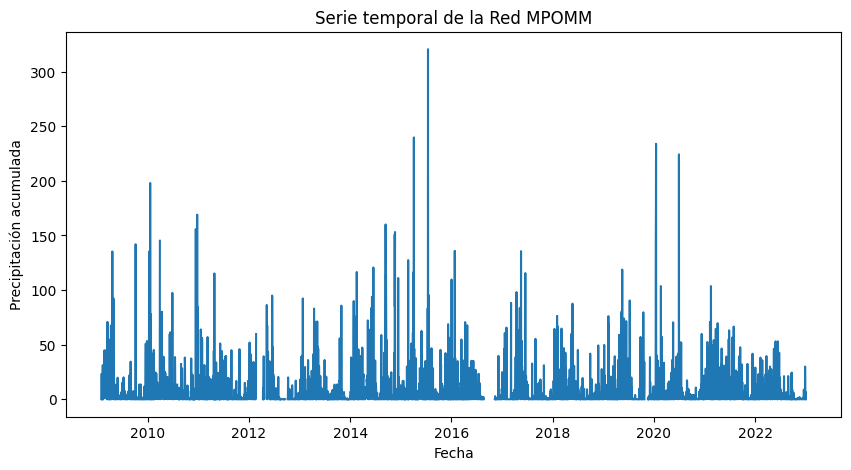

In [4]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(10,5))

plt.plot(serie)
plt.title('Serie temporal de la Red MPOMM')
plt.ylabel(params['variable_name'])
plt.xlabel('Fecha')
plt.show()

### CHIRPS

- Consulta a la base de datos
    Al igual que la etapa anterior, con los datos recolectados de la base de datos de chirp que luego se alojaron en el datalake y luego fueron procesados transformados y carrgados (etl), a la base de datos de mongo, relaizaremos las consultas para poder obtener los datos y su preprocesamieto.

In [12]:
from pymongo import MongoClient
import pandas as pd
import numpy as np

# Conectar a MongoDB
client = MongoClient('localhost', 27017)  # Ajusta según configuración
db = client['CHIRPS']
collection = db['tumaco']

# 1️⃣ Extraer coordenadas únicas de red_mpomm_serie
unique_coords = red_mpomm_serie[['latitude', 'longitude']].drop_duplicates().values
latitude_mpomm, longitude_mpomm = unique_coords[0]  # Tomamos el primer punto único

print(f"Coordenada de referencia MPOMM: ({latitude_mpomm}, {longitude_mpomm})")

# 2️⃣ Obtener todos los puntos de MongoDB
data = list(collection.find({}, {'point_data.latitude': 1, 'point_data.longitude': 1, '_id': 0}))

# Extraer coordenadas únicas de MongoDB
mongo_coords = set()
for doc in data:
    for point in doc.get('point_data', []):
        mongo_coords.add((point['latitude'], point['longitude']))

# Convertir a lista para cálculos
mongo_coords = list(mongo_coords)

# 3️⃣ Encontrar las 2 coordenadas más cercanas en MongoDB
def distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

distances = [(coord, distance((latitude_mpomm, longitude_mpomm), coord)) for coord in mongo_coords]
distances.sort(key=lambda x: x[1])  # Ordenar por distancia

nearest_coords = [distances[0][0], distances[1][0]]
print(f"Coordenadas más cercanas encontradas en MongoDB: {nearest_coords}")

# 4️⃣ Extraer datos de MongoDB para estas coordenadas
filtered_points = []
for doc in collection.find():
    timestamp = doc.get('timestamp')
    for point in doc.get('point_data', []):
        if (point['latitude'], point['longitude']) in nearest_coords:
            filtered_points.append({
                'point_id': point['point_id'],
                'latitude': point['latitude'],
                'longitude': point['longitude'],
                'value': point['value'],
                'timestamp': timestamp
            })

# 5️⃣ Convertir a DataFrame
df = pd.DataFrame(filtered_points)
# Convertir 'timestamp' a tipo fecha
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Mostrar resultados
print("DataFrame final con puntos más cercanos:")
df.head()


Coordenada de referencia MPOMM: (1.82011, -78.72871)
Coordenadas más cercanas encontradas en MongoDB: [(1.82011, -78.72871), (1.824997, -78.725006)]
DataFrame final con puntos más cercanos:


,point_id,latitude,longitude,value,timestamp
0,point_1,1.820110,-78.728710,0.000000,2009-02-01
1,point_10,1.824997,-78.725006,0.000000,2009-02-01
2,point_1,1.820110,-78.728710,0.700000,2009-02-02
3,point_10,1.824997,-78.725006,12.457714,2009-02-02
4,point_1,1.820110,-78.728710,23.300000,2009-02-03


Se obtiene la informacion de la base de datos en mongo, ahora se procede a realizar el proceso de transformacion de los datos, para poder trabajar junto a la serie de la red mpomm.

2. Preprocesamiento de los datos
    
- obtencion de datos
    
    Se deben crear series temporales de cada punto geografico.

In [13]:
import pandas as pd

# Suponiendo que df es tu dataset original
#df['timestamp'] = pd.to_datetime(df['timestamp'])  # Asegurar que sea datetime

# Crear la tabla pivotante con fecha como índice y cada punto como columna
series_chirps = df.pivot_table(index='timestamp', columns='point_id', values='value')

# Mostrar el DataFrame resultante
display(series_chirps)


point_id,point_1,point_10
timestamp,,
2009-02-01,0.0,0.000000
2009-02-02,0.7,12.457714
2009-02-03,23.3,12.457714
2009-02-04,0.0,0.000000
2009-02-05,0.0,0.000000
...,...,...
2022-12-28,2.1,0.000000
2022-12-29,0.5,0.000000
2022-12-30,0.0,0.000000


Se obtiene un dataframe **series_chirps** con las series temporales de cada punto geografico seleccionado.

- Filtrado
    
    Ahora podemos realizar el proceso de **filtrado** de control de calidad como manejo de nan o de outlyers

In [14]:
# Convertir el índice de series_chirps a naive (sin zona horaria)
series_chirps.index = series_chirps.index.tz_localize(None)
# Reemplazar los valores mayores a 500 por NaN
series_chirps = series_chirps.mask(series_chirps > 500)
#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
series_chirps.isnull().sum()

point_id
point_1     431
point_10      1
dtype: int64

Se imponen condiciones o reglas de filtrado para limpiar la señal

## Dataset

Como parte final de este proceso se realiza la union de los datos a trabajar en un solo dataframe para mayor facilidad en la manipulacion de los mismos.

In [15]:

# crear el dataset

dataset = pd.DataFrame()
# Si dataset también tiene una columna de fecha, conviértela a datetime sin zona horaria
dataset.index = pd.to_datetime(dataset.index).tz_localize(None)

# Convertir 'serie' en DataFrame y unir con 'series_chirps'
dataset = serie.to_frame().join(series_chirps, how="inner")
display(dataset.shape)
dataset.head()


(5083, 3)

,tumaco,point_1,point_10
timestamp,,,
2009-02-01,0.0,0.0,0.000000
2009-02-02,0.7,0.7,12.457714
2009-02-03,23.3,23.3,12.457714
2009-02-04,0.0,0.0,0.000000
2009-02-05,0.0,0.0,0.000000


### Transformaciones al dataset

Se tealizan distintas transformaciones al dataset con el fin de realizar preprocesamiento estadistico para adecuar las series a los modelos antes de pasar los daots para el entrenamiento 

In [16]:
# Remuestrear el dataset con datos

dataset = dataset.resample('W').apply(lambda g: custom_resample(g, nan_threshold=0.2))
print('Reporte de datos NaN por columna: ')
print(dataset.isnull().sum(),'\n')

Reporte de datos NaN por columna: 
tumaco      53
point_1     89
point_10     0
dtype: int64 



In [17]:
# Función para categorizar la precipitación
def categorizar_precipitacion(valor, min_val, max_val):
    # Normalizar el valor entre 0 y 1
    scaled_value = (valor - min_val) / (max_val - min_val)
    
    # Ajustar las categorías basadas en el valor escalado
    if valor == 0:
        return 1
    elif 0 < scaled_value <= 0.1:
        return 2
    elif 0.1 < scaled_value <= 0.2:
        return 3
    elif 0.2 < scaled_value <= 0.3:
        return 4
    elif 0.3 < scaled_value <= 0.4:
        return 5
    elif 0.4 < scaled_value <= 0.5:
        return 6
    elif 0.5 < scaled_value <= 0.6:
        return 7
    elif 0.6 < scaled_value <= 0.7:
        return 8
    elif 0.7 < scaled_value <= 0.8:
        return 9
    else:
        return 10

# Aplicar la categorización a cada columna basándonos en el min y max de cada columna
for col in dataset.columns:
    min_val = dataset[col].min()
    max_val = dataset[col].max()
    #dataset[f'{col}_categoria'] = dataset[col].apply(lambda x: categorizar_precipitacion(x, min_val, max_val))



"""def categorizar_precipitacion(valor):
    if valor == 0:
        #return 'Sin lluvia'
        return 1
    elif 0 < valor <= 5:
        #return 'Lluvia ligera'
        return 2
    elif 5 < valor <= 20:
        #return 'Lluvia moderada'
        return 3
    else:
        #return 'Lluvia intensa'
        return 4"""



# Mostrar el DataFrame con las nuevas columnas de categorización
display(dataset.head(5))

,tumaco,point_1,point_10
timestamp,,,
2009-02-01,0.0,0.0,0.000000
2009-02-08,29.5,29.5,24.915428
2009-02-15,58.9,58.9,52.841744
2009-02-22,26.1,26.1,20.093560
2009-03-01,75.0,63.6,41.724288


- distribucion de los datos 

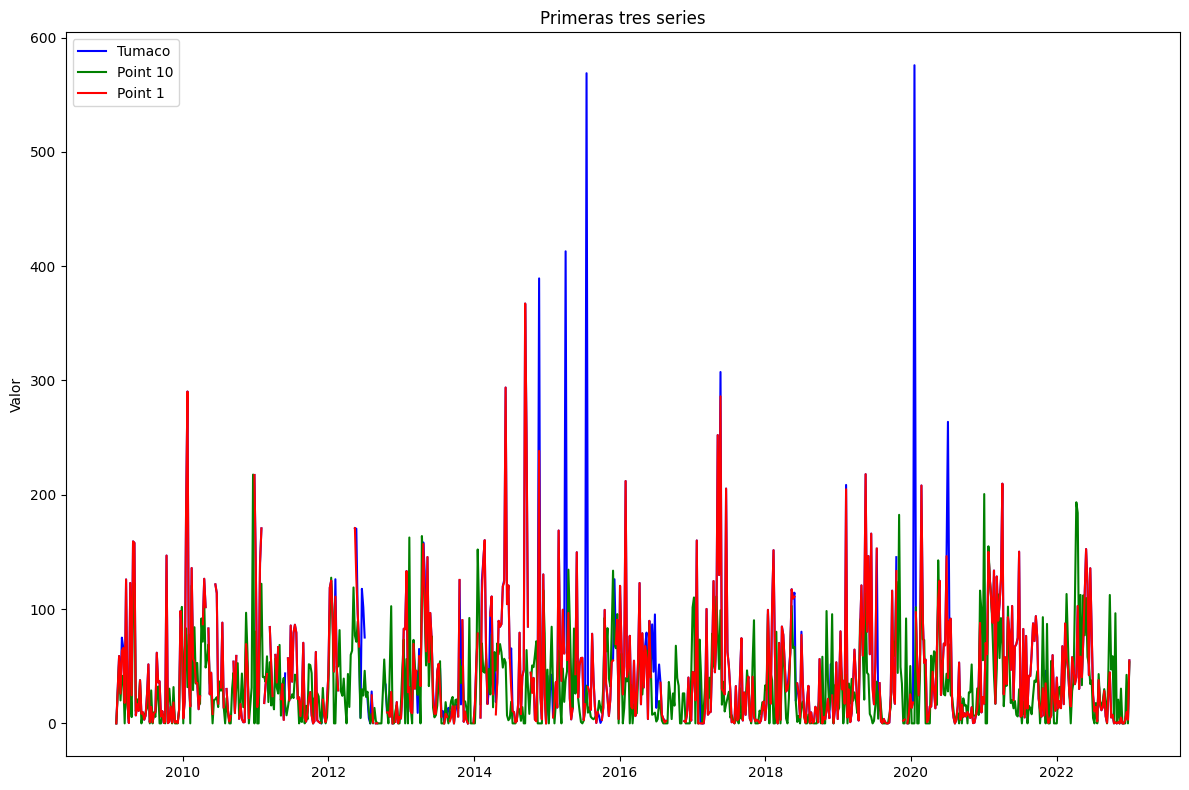

In [19]:
import matplotlib.pyplot as plt

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8), sharex=True)

# Graficar las tres primeras series en el mismo subplot
ax.plot(dataset.index, dataset["tumaco"], label="Tumaco", color="blue")
ax.plot(dataset.index, dataset["point_10"], label="Point 10", color="green")
ax.plot(dataset.index, dataset["point_1"], label="Point 1", color="red")

# Configurar título y etiquetas
ax.set_title('Primeras tres series')
ax.set_ylabel('Valor')
ax.legend(loc='upper left')

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()


In [20]:
# Aplicar transformación recíproca con un pequeño valor para evitar división por cero
from math import log1p


epsilon = 1e-6
#dataset_transformed = 1 / (dataset + epsilon)
#dataset_transformed_filtered = dataset_transformed[dataset_transformed  10]
dataset_transformed = np.log1p(dataset)
# Filtrar el DataFrame para que solo queden los valores menores a 100





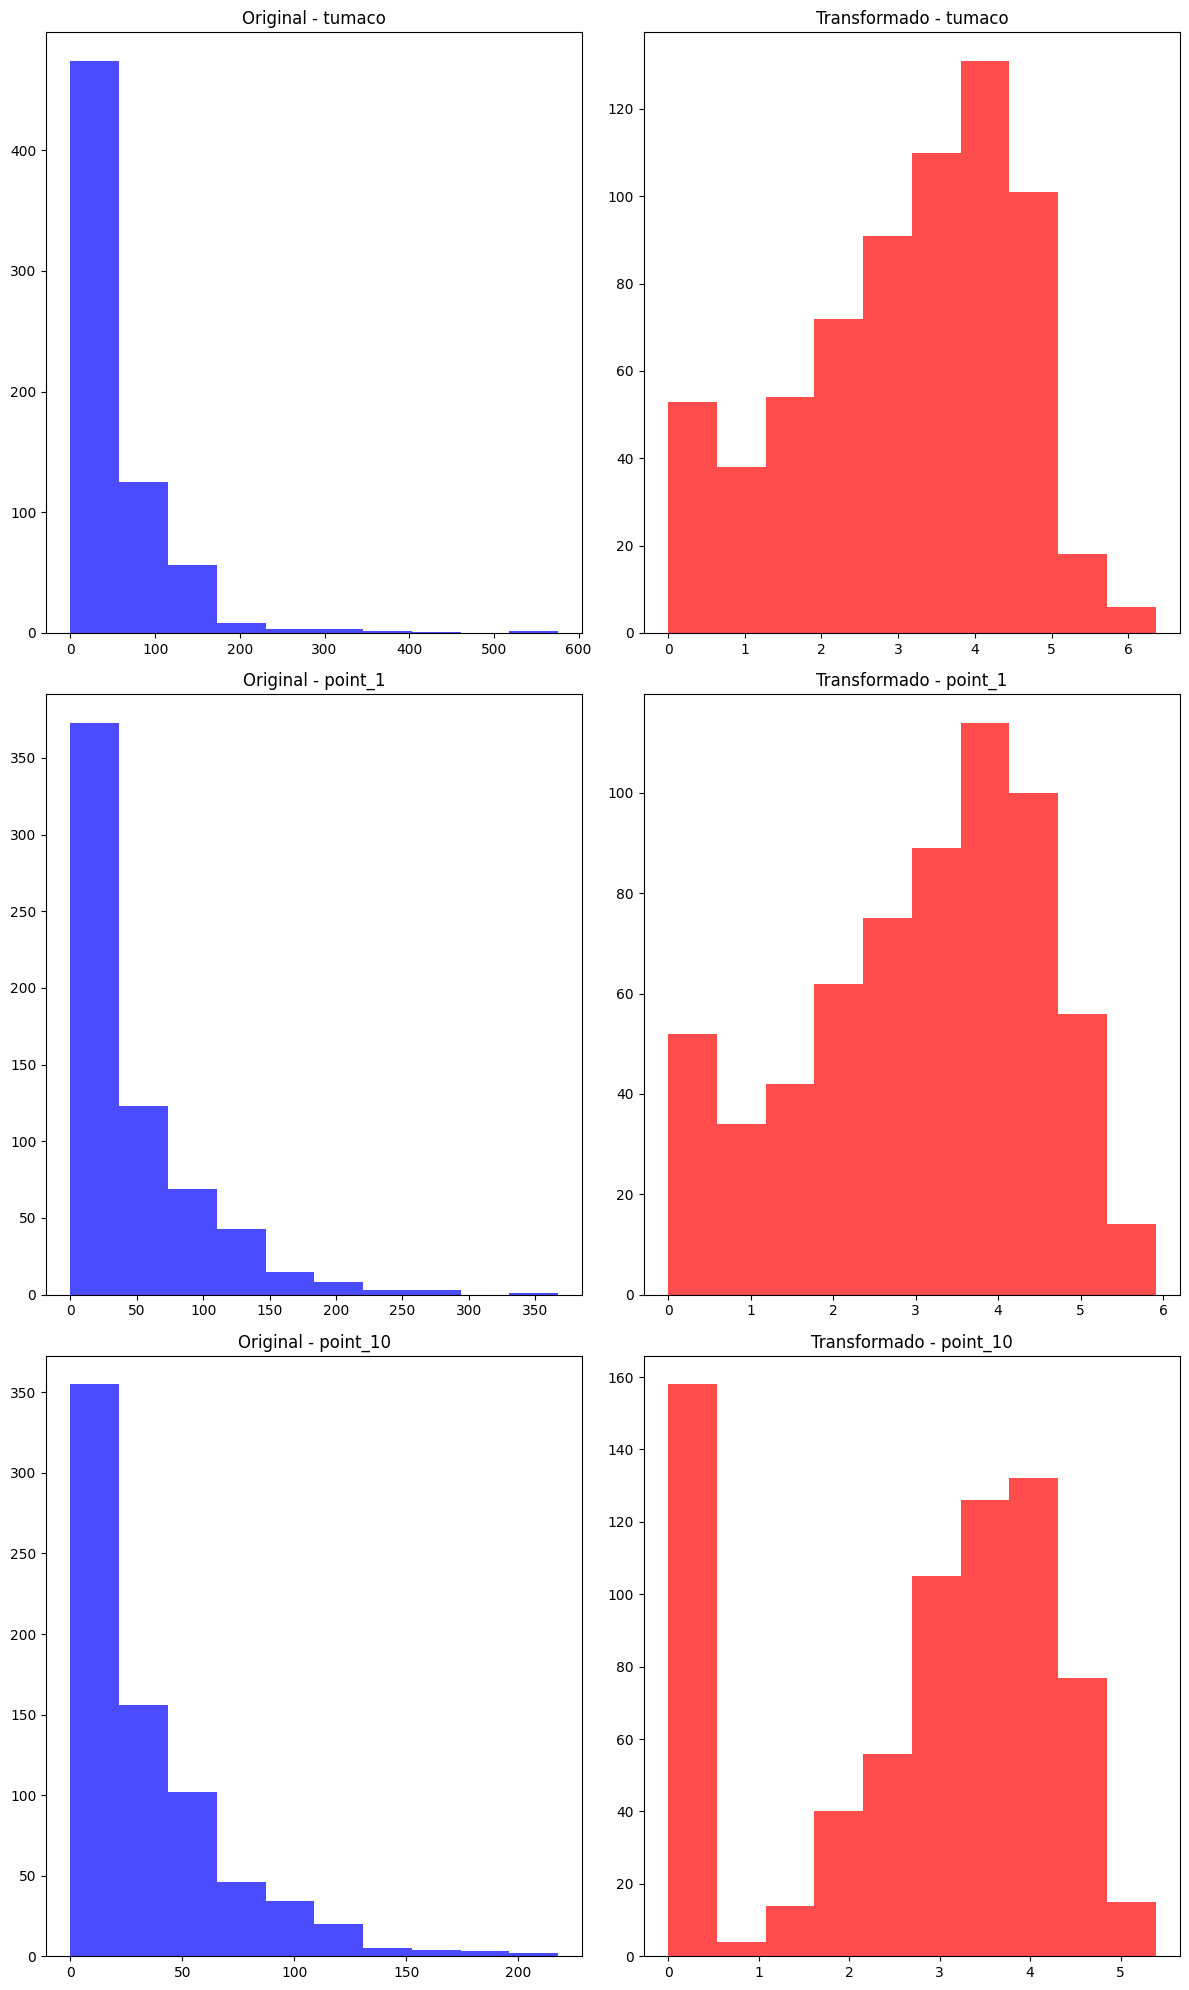

In [21]:

# Crear la figura con subplots
fig, axs = plt.subplots(nrows=dataset.shape[1], ncols=2, figsize=(12, 20))

# Recorrer cada columna y graficar sus histogramas antes y después
for i, col in enumerate(dataset.columns):
    axs[i, 0].hist(dataset[col], bins=10, color='blue', alpha=0.7)
    axs[i, 0].set_title(f'Original - {col}')
    
    axs[i, 1].hist(dataset_transformed[col], bins=10, color='red', alpha=0.7)
    axs[i, 1].set_title(f'Transformado - {col}')

# Ajustar diseño
plt.tight_layout()
plt.show()


## Analisis de la imputacion
---
1. Analisis visual
    - Grafica temporal para ver el estado de las series

In [22]:
print(dataset.describe())
print('La cantidad de nulos \n ', dataset.isnull().sum())
print('La cantidad de nan \n ', dataset.isna().sum())

           tumaco     point_1    point_10
count  674.000000  638.000000  727.000000
mean    48.011276   45.108621   33.219059
std     62.019120   51.705863   35.909445
min      0.000000    0.000000    0.000000
25%      7.500000    6.900000    4.622516
50%     27.550000   26.600000   22.694370
75%     67.650000   67.000000   49.931406
max    575.800000  367.300000  217.662451
La cantidad de nulos 
  tumaco      53
point_1     89
point_10     0
dtype: int64
La cantidad de nan 
  tumaco      53
point_1     89
point_10     0
dtype: int64


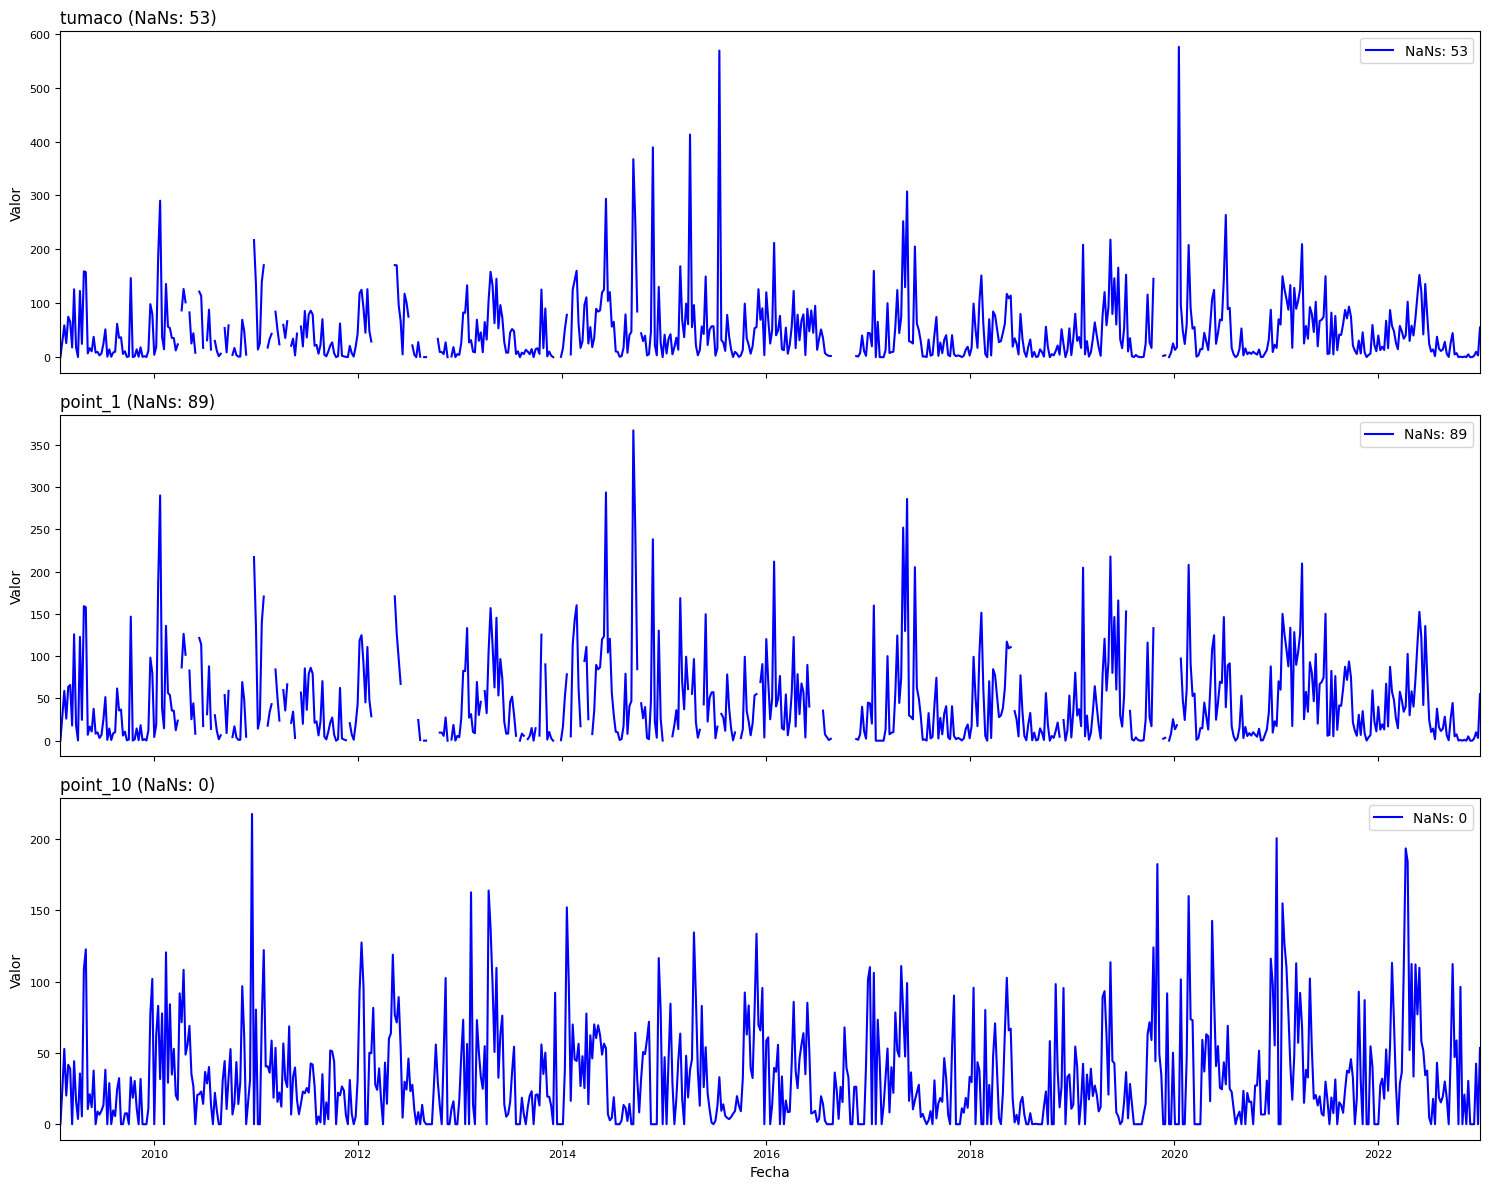

In [23]:
import matplotlib.pyplot as plt

# Crear la figura con subgráficos (uno por cada columna del dataset)
fig, axs = plt.subplots(nrows=dataset.shape[1], ncols=1, figsize=(15, 12), sharex=True)

# Si solo hay una serie, convertir axs en una lista para evitar errores
if dataset.shape[1] == 1:
    axs = [axs]

# Recorrer cada columna del dataset y graficarla
for i, col in enumerate(dataset.columns):
    ax = axs[i]  # Seleccionar el subplot correspondiente
    nan_count = dataset[col].isna().sum()  # Contar los NaNs en la serie
    
    # Graficar la serie con etiqueta de cantidad de NaNs
    ax.plot(dataset.index, dataset[col], color='blue', label=f'NaNs: {nan_count}')
    ax.set_ylabel('Valor', fontsize=10)
    ax.set_title(f"{col} (NaNs: {nan_count})", fontsize=12, loc='left')
    
    # Configuración de ejes
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(dataset.index.min(), dataset.index.max())
    ax.legend(loc='upper right')

# Ajustar espacio entre subgráficos
plt.subplots_adjust(hspace=0.3)
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()



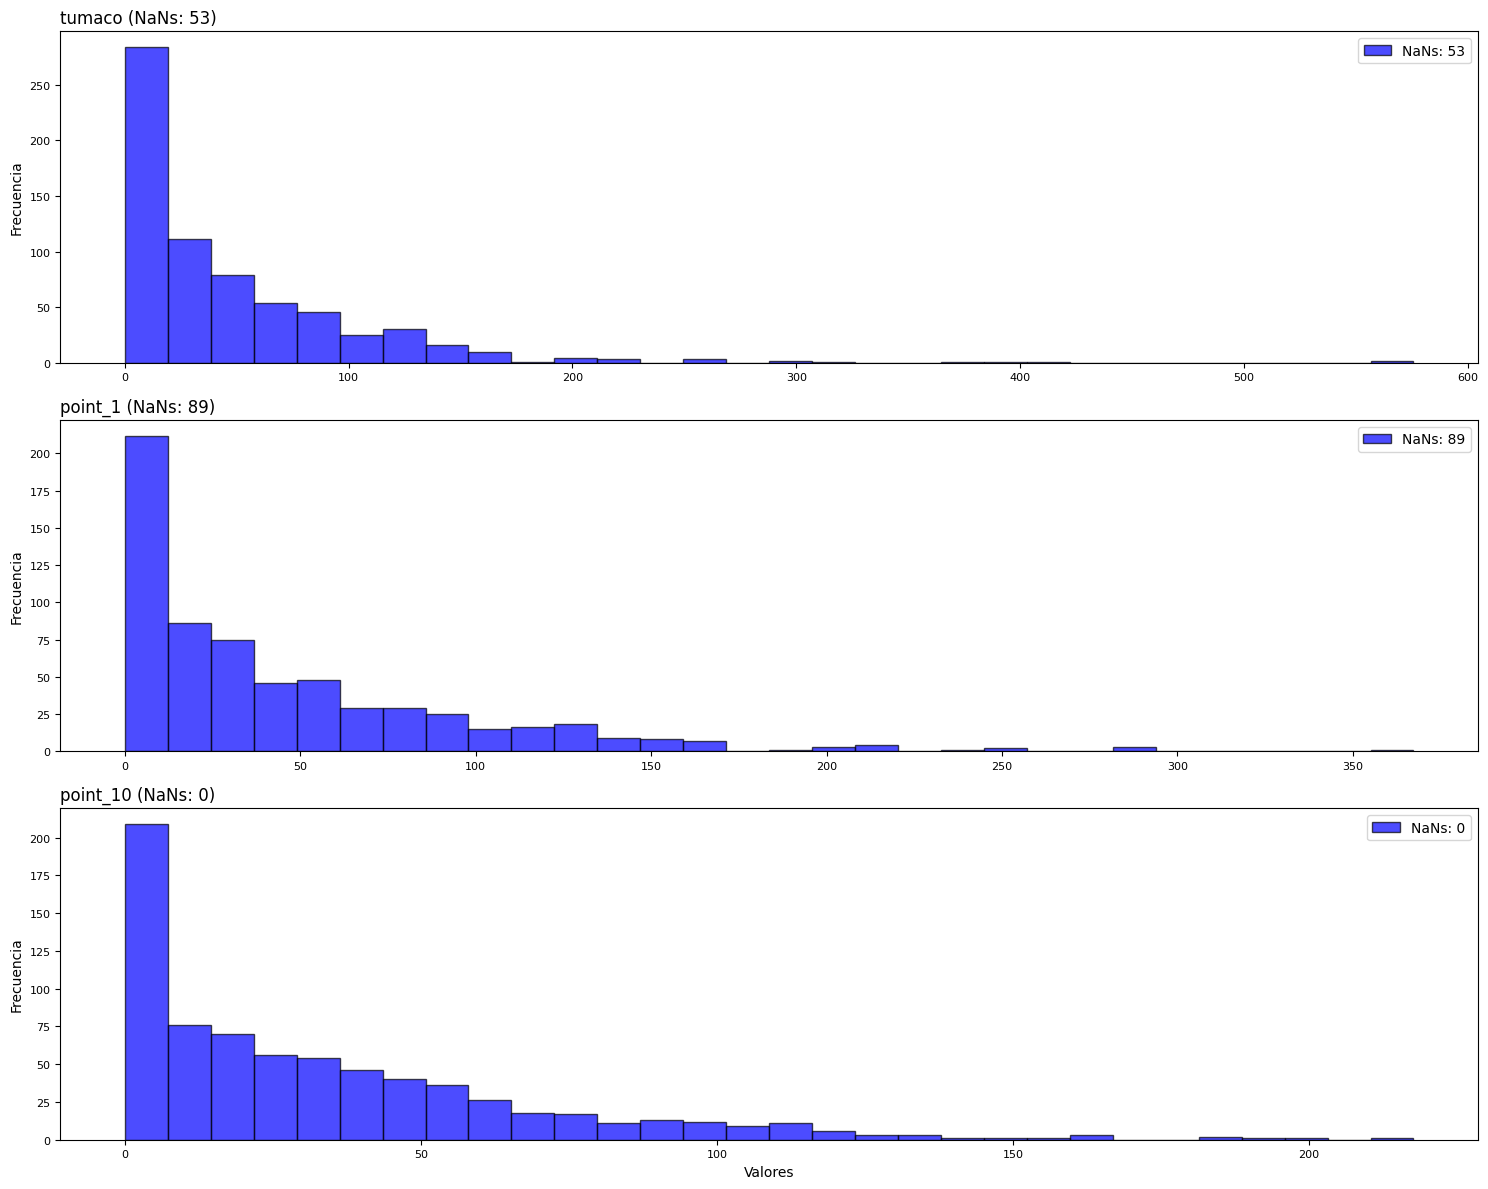

In [24]:
import matplotlib.pyplot as plt

# Crear la figura con subgráficos (uno por cada columna del dataset)
fig, axs = plt.subplots(nrows=dataset.shape[1], ncols=1, figsize=(15, 12), sharex=False)

# Si solo hay una serie, convertir axs en una lista para evitar errores
if dataset.shape[1] == 1:
    axs = [axs]

# Recorrer cada columna del dataset y graficar su histograma
for i, col in enumerate(dataset.columns):
    ax = axs[i]  # Seleccionar el subplot correspondiente
    nan_count = dataset[col].isna().sum()  # Contar los NaNs en la serie
    
    # Graficar el histograma con etiqueta de cantidad de NaNs
    ax.hist(dataset[col].dropna(), bins=30, color='blue', alpha=0.7, edgecolor='black', label=f'NaNs: {nan_count}')
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.set_title(f"{col} (NaNs: {nan_count})", fontsize=12, loc='left')
    
    # Configuración de ejes
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.legend(loc='upper right')

# Ajustar espacio entre subgráficos
plt.subplots_adjust(hspace=0.3)
plt.xlabel("Valores")
plt.tight_layout()
plt.show()


En estas se ve que la serie de tumaco es la que presenta mas numero de ausentes, estos son lo objetivos a rellenar, en las otras tambien se precentan ausentes, unas de las posibles causas es el umbral de filtrado anteriormente aplicado o la ausencia del dato dentro de la base de datos.

- Ajuste de dataset

    En este paso se **eliminan** las filas con **NaN** contenidas en el data set, y se almacenan en otra variable.

In [25]:
# Crear un dataframe con solo las filas con datos en todas las columnas
dataset_no_nan = dataset.dropna()
dataset_no_nan.shape

(638, 3)

- Remuestreo del dataset

    Se aplica la funcion de remuestreco dejando pasar los datos que tengan el **20%** de **NaN* como maximo umbral permitido.

- Graficas

    Se crea un grafico de correlaciones las cuales permiten visualizar la distribucion de la correlacion cruzada de las series ente series, tambien una tabla con la estimacion numerica de las correlaciones

,tumaco,point_1,point_10
tumaco,1.000000,0.977822,0.464420
point_1,0.977822,1.000000,0.483399
point_10,0.464420,0.483399,1.000000


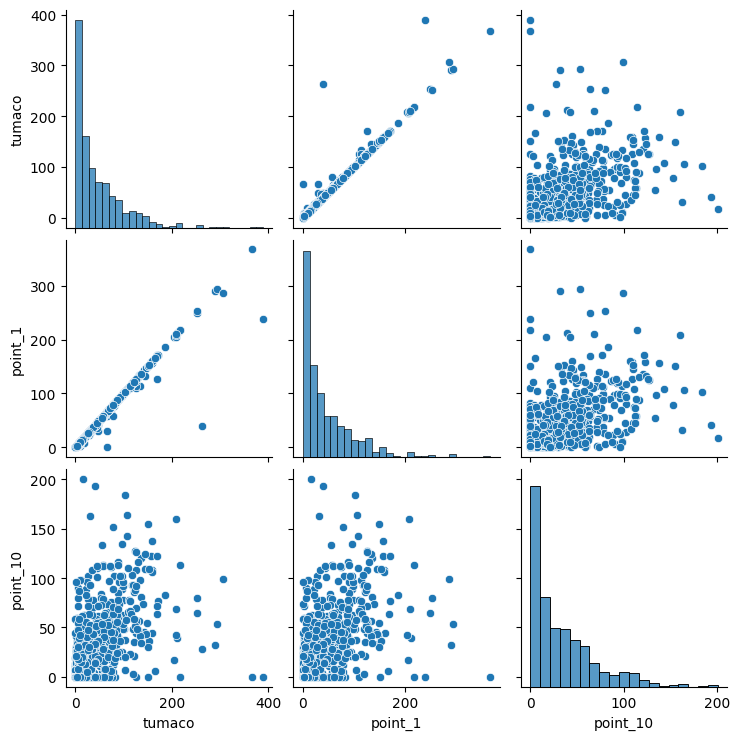

In [26]:
#dataset_no_nan=dataset_no_nan.iloc[:,-4:]
import seaborn as sns
sns.pairplot(dataset_no_nan)
dataset_no_nan.corr()

- Mapa de calor

    Se crea un mapa de calor de las correlaciones para poder visualizar de manera adecuada y analizar las series.

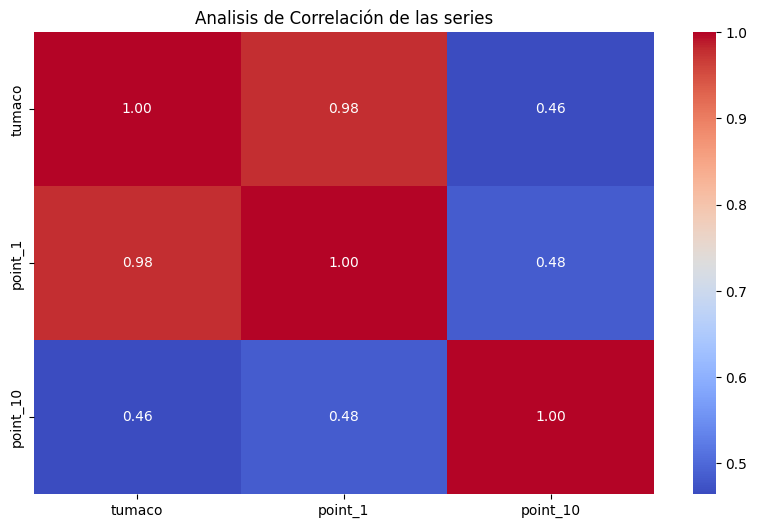

In [27]:
# Crear el heatmap de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(dataset_no_nan.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Analisis de Correlación de las series")
plt.show()

En esta nos debemos centrar en la fila y columna de tumaco ya que es la que debemos predecir para recuperar los datos, entonces podemos analizar que se correlacionan al rededor del *60%* de las demas series. es pertinente continual con el analisis exploratorio

###  Creacion del modelo de imputacion




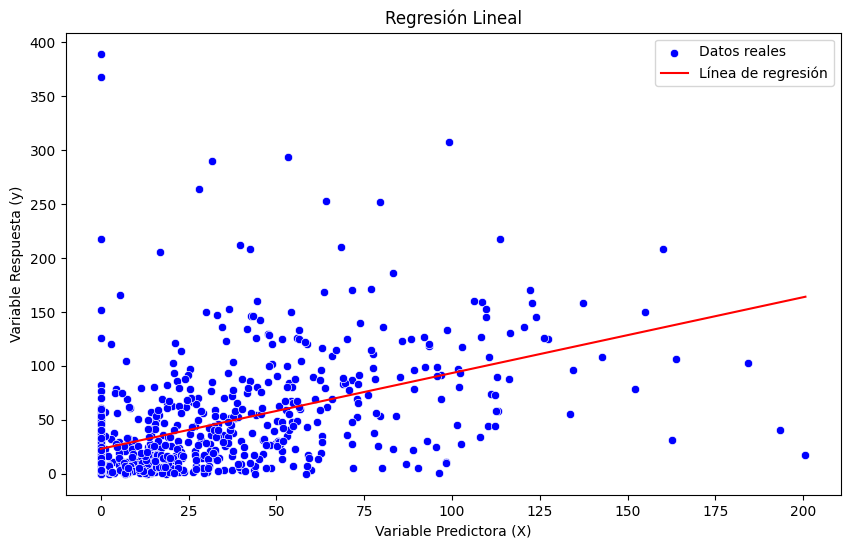

Ecuación de la recta: y = 0.7x + 23.04
Coeficiente de correlación: 0.46
Coeficiente de determinación (R²): 0.22


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Supongamos que dataset_no_nan es tu DataFrame sin valores nulos
# Asegúrate de que las columnas 2 y 1 sean las correctas para X e y
X = dataset_no_nan.iloc[:, 2].values.reshape(-1, 1)  # Variable predictora (columna 2)
y = dataset_no_nan.iloc[:, 0].values  # Variable respuesta (columna 1)

# Crear y entrenar el modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X, y)

# Predecir valores para la línea de regresión
y_pred = modelo.predict(X)

# Gráfico de dispersión con línea de regresión
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X.flatten(), y=y, color='blue', label='Datos reales')
sns.lineplot(x=X.flatten(), y=y_pred, color='red', label='Línea de regresión')
plt.title('Regresión Lineal')
plt.xlabel('Variable Predictora (X)')
plt.ylabel('Variable Respuesta (y)')
plt.legend()
plt.show()

# Mostrar ecuación de la recta
print(f"Ecuación de la recta: y = {round(float(modelo.coef_[0]), 2)}x + {round(float(modelo.intercept_), 2)}")

# Coeficiente de correlación
corr = np.corrcoef(X.flatten(), y)[0, 1]
print(f"Coeficiente de correlación: {round(corr, 2)}")

# Coeficiente de determinación (R^2)
r2 = r2_score(y, y_pred)
print(f"Coeficiente de determinación (R²): {round(r2, 2)}")

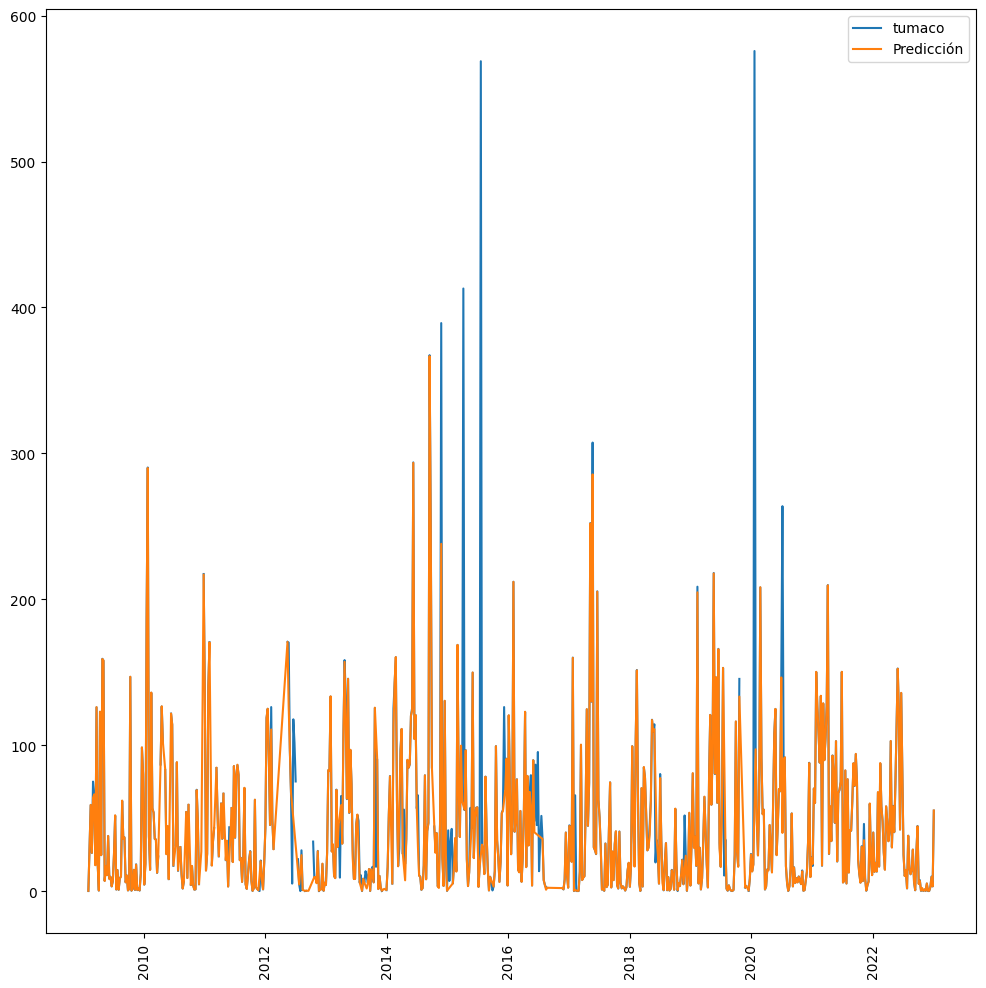

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

#Datos y/ variables
xTrain = dataset_no_nan.iloc[:,1:] # Variables predictora (dataframe)
yTrain = dataset_no_nan.iloc[:,1] # Variable a predicir (lista)
#Establecer un escalador para hacer homogeneos los datos en la predicción 
scaler = StandardScaler().fit(xTrain.values)
xTrainScaled = scaler.transform(xTrain.values)
# Generar el modelo de regresión de red neural
regr = MLPRegressor(random_state=1, max_iter=5000).fit(xTrainScaled, yTrain)
#test - realizamos prueba de predicción con los datos X
xTest = dataset.iloc[:,1:].dropna()
xTestScaled = scaler.transform(xTest.values)
# realizamos la predicción en los datos y
yPredict = regr.predict(xTestScaled)
#comparison of station 2
fig, ax=plt.subplots(figsize=(12,12),sharex=True,sharey=True)
ax.plot(dataset.index,dataset.iloc[:,:1],label=dataset.columns[0])#ajuste
ax.plot(xTest.index,yPredict,label='Predicción')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

In [30]:
# Se crea una nueva columna para agregar los datos
dataset[dataset.columns[0]+"_imputada"] = 0 #ajustar
# Agregar los datos en la matriz (se agregan solamente predicciones donde no hay datos observados)

for index, row in dataset.iterrows():
    if np.isnan(row[dataset.columns[0]]) and ~np.isnan(row[dataset.columns[1]]) and ~np.isnan(row[dataset.columns[2]]):
        row_input = np.array([[np.nan, row[dataset.columns[1]], row[dataset.columns[2]]]])

        # Asegurar que el número de características coincida con scaler
        rowScaled = scaler.transform(np.nan_to_num(row_input)) 

        # Realizar la predicción y convertir el resultado a float explícitamente
        predicted_value = float(regr.predict(rowScaled)[0])  

        # Asignar el valor asegurando que el tipo de dato es compatible
        dataset.loc[index, dataset.columns[0] + "_imputada"] = predicted_value

    elif ~np.isnan(row[dataset.columns[0]]): #ajustar
        dataset.loc[index,[dataset.columns[0]+"_imputada"]] = row[dataset.columns[0]] #ajustar 
    else:
        row[dataset.columns[0]+"_imputada"] = np.nan #ajustar


C:\Users\dreng\AppData\Local\Temp\ipykernel_23312\4114675070.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '29.499999999999996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[index,[dataset.columns[0]+"_imputada"]] = row[dataset.columns[0]] #ajustar


In [31]:
import plotly.graph_objects as go

# Crear la figura
fig = go.Figure()

# Añadir la serie de datos original (ajuste)
fig.add_trace(go.Scatter(x=dataset.index, y=dataset.iloc[:, 0], mode='lines', name=dataset.columns[0]))

# Añadir la predicción
fig.add_trace(go.Scatter(x=xTest.index, y=yPredict, mode='lines', name='Predicción'))

#Añadir imputada
fig.add_trace(go.Scatter(x=dataset.index, y=dataset.iloc[:,-1], mode='lines', name=dataset.columns[-1] ))

# Añadir leyenda
fig.update_layout(
    title="Comparison of Station 2",
    xaxis_title="Timestamp",
    yaxis_title="Value",
    xaxis_tickangle=-90,
    legend_title="Legend",
    template="plotly",
)

# Mostrar la figura
fig.show()


## **Imputaicon de datos**
---
- Visualizar el estado inicial del *dataset* en cuestrion de valores nulos  y Nan para tener idea de los rellenos 

In [32]:
dataset.isna().sum()

tumaco             53
point_1            89
point_10            0
tumaco_imputada     0
dtype: int64

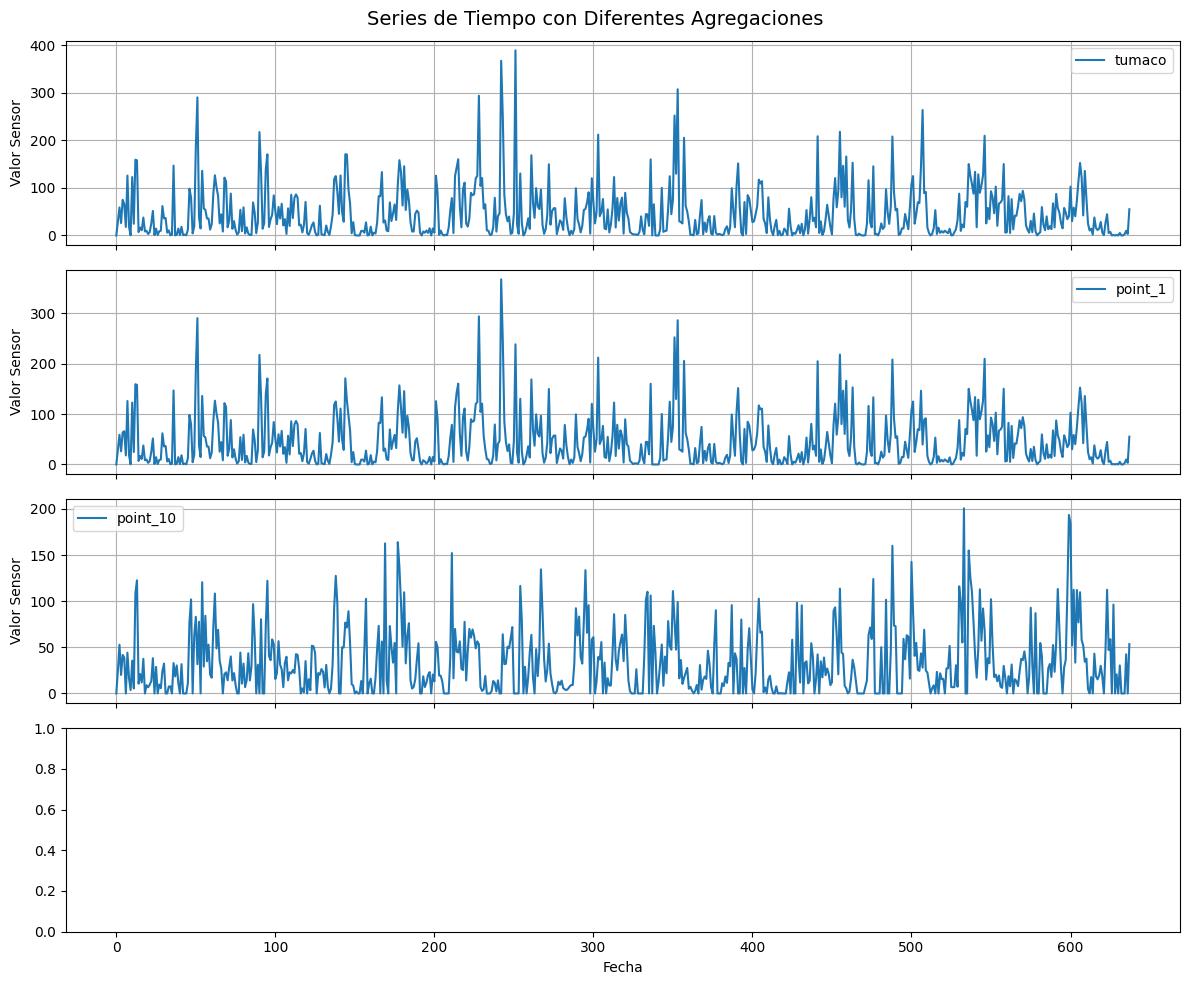

In [33]:
import matplotlib.pyplot as plt

#dataset_no_nan es un DataFrame con varias columnas
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Usando zip para iterar a través de las columnas y sus títulos
for ax, data, title in zip(axes, dataset_no_nan.values.T, dataset_no_nan.columns):
    ax.plot(data, linestyle='-', label=title)
    ax.set_ylabel("Valor Sensor")
    ax.legend()
    ax.grid(True)

# Configurar el título general
plt.suptitle("Series de Tiempo con Diferentes Agregaciones", fontsize=14)
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()


Como vemos en este caso tenemos distintos esenarios dependiendo del año, podemos analizar que existen sereis que tienen baches pequeños y otras que tienen grandes periodos de ausencias de datos.
En las siguientes etapas trataremos cada año de manera individual para realizar el reyeno de los datos, comenzamos con el reyeno de las series que tienen menos cantidad de datos faltantes.

## Imputacion de series temporales
---

Comenzamos con la inspeccion visual detallada de la serie, para este caso particular comenzamos con la serie de 2009.

1. Grafica temporal


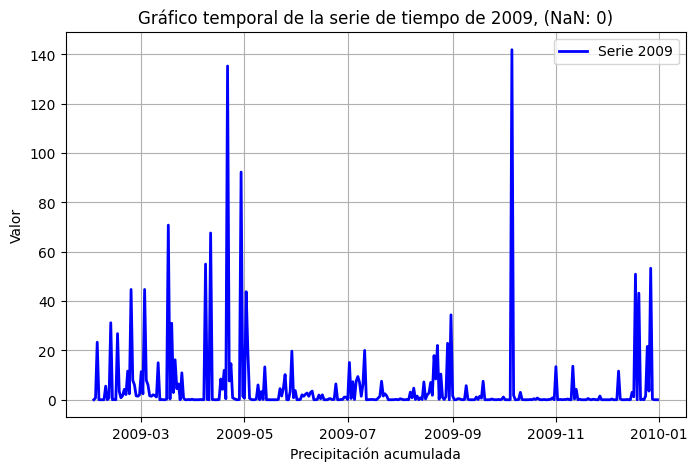

In [34]:
# Filtrar datos del año 2009
year = 2009
data = serie[serie.index.year == year]

# Crear la figura
plt.figure(figsize=(8, 5))
plt.plot(data.index, data.values, label=f'Serie {year}', linewidth=2, color="b")

# Etiquetas y título
plt.xlabel(params['variable_name'])
plt.ylabel("Valor")
plt.title(f'Gráfico temporal de la serie de tiempo de {year}, (NaN: {data.isna().sum()})')
plt.legend()
plt.grid()

# Mostrar la gráfica
plt.show()


# Analisis estadistico


- Analisis descriptivo

Para esto realizamos una serie de graficas temporales para distintos instantes de remuestreo con el fin de obtener patrones y tendencias en el tiempo.

### Grafico temporal
En estos graficos se pretende comprender la naturaleza de los datos es decir como es el comportamiento a lo largo del tiempo, asi mismo se estima visualmente cuantos baches y de que tamaño se tienen en la serie

Para la series remuestreadas se utilizan criterios variables, es decir, si el 20% de los datos de la semana son nulos entonces el acumulado semanal correspondiente tambien sera nulo. asi tenemos un criterio de calidad para poder determinar con cuantos datos de la serie trabajamos.

timestamp
2009-02-01    0.0
2009-02-02    0.7
Freq: D, Name: tumaco, dtype: float64

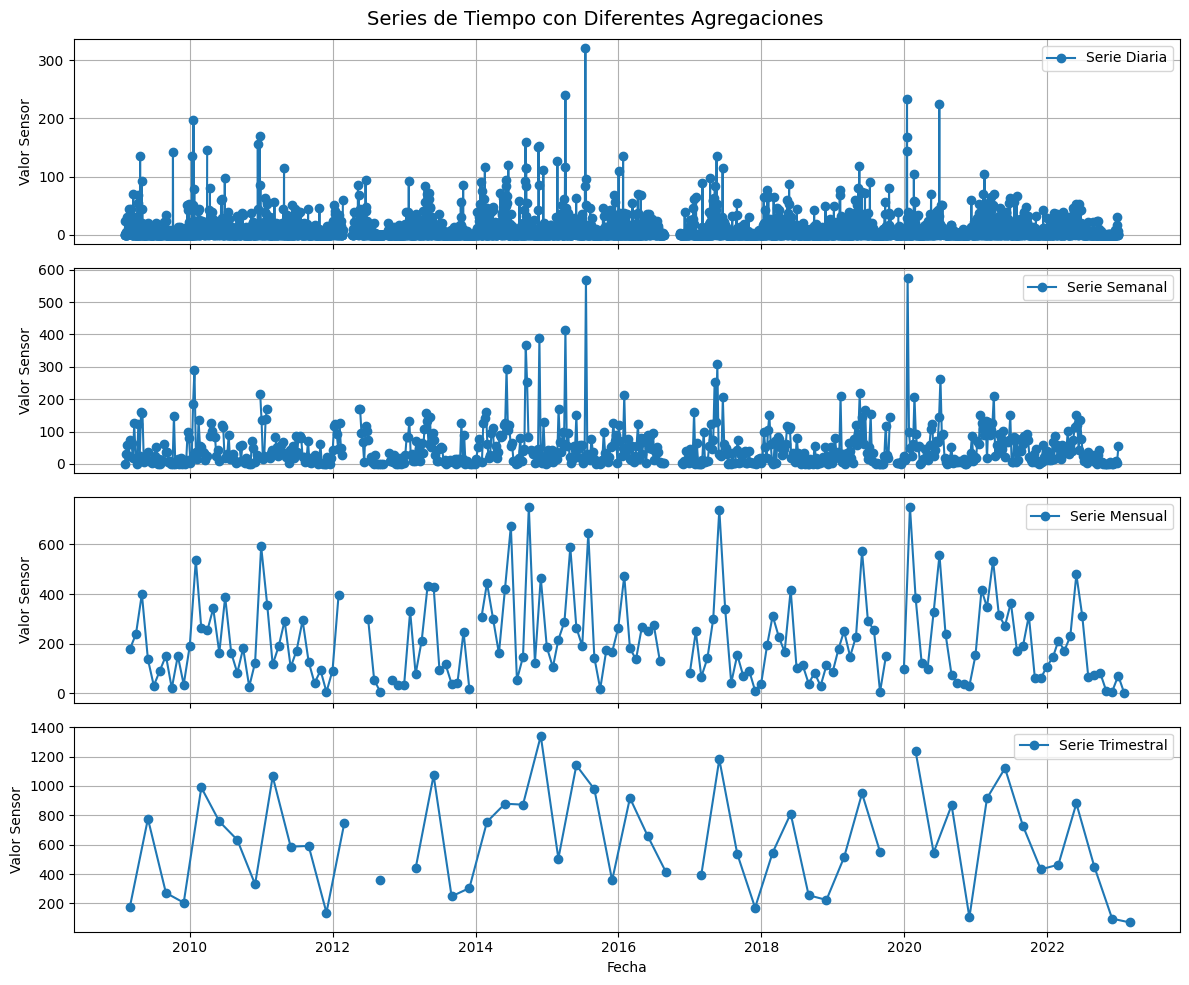

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Resampleo con diferentes períodos de agregación
daily_serie = serie.resample('D').apply(lambda g: custom_resample(g, nan_threshold=0.2))
weekly_serie = serie.resample('W').apply(lambda g: custom_resample(g, nan_threshold=0.2))
monthly_serie = serie.resample('ME').apply(lambda g: custom_resample(g, nan_threshold=0.2))
quarterly_serie = serie.resample('3ME').apply(lambda g: custom_resample(g, nan_threshold=0.2))
display(serie.head(2))
# Crear figura con subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Definir títulos y datos
series = [daily_serie, weekly_serie, monthly_serie, quarterly_serie]
titles = ["Serie Diaria", "Serie Semanal", "Serie Mensual", "Serie Trimestral"]

for ax, data, title in zip(axes, series, titles):
    ax.plot(data, marker='o', linestyle='-', label=title)
    ax.set_ylabel("Valor Sensor")
    ax.legend()
    ax.grid(True)

# Configurar el título general
plt.suptitle("Series de Tiempo con Diferentes Agregaciones", fontsize=14)
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()


### Grafico de dstribucion de los datos
En estos graficos se presentan las distribuciones de cada serie, con esto se pretende tener una vision estadistica de la centralizacion de las series.

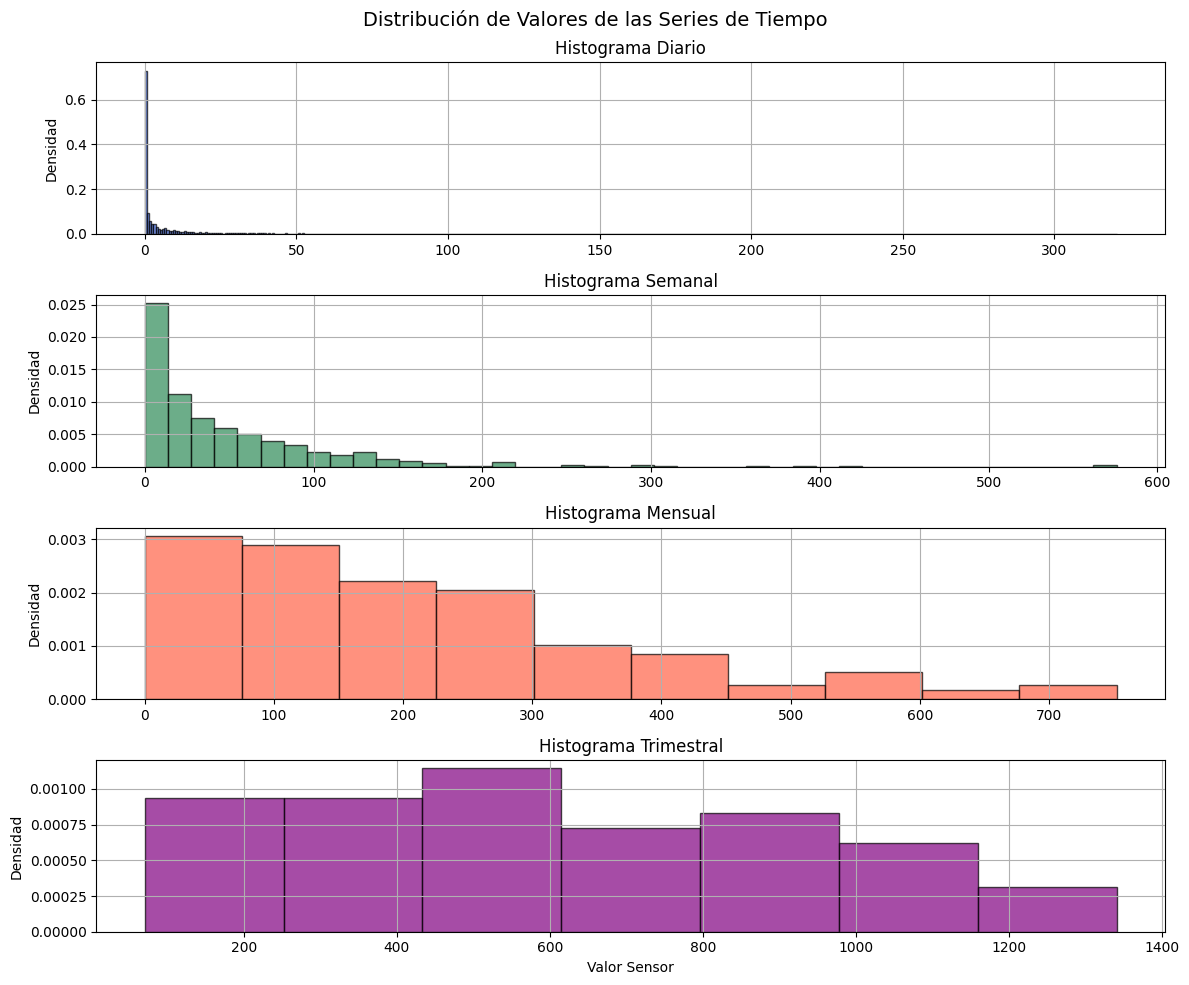

In [36]:
import matplotlib.pyplot as plt

# Crear figura con subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 10))  # No compartimos ejes

# Definir datos, títulos y colores
series = [daily_serie, weekly_serie, monthly_serie, quarterly_serie]
titles = ["Histograma Diario", "Histograma Semanal", "Histograma Mensual", "Histograma Trimestral"]
colors = ['royalblue', 'seagreen', 'tomato', 'purple']  # Colores diferenciados

for ax, data, title, color in zip(axes, series, titles, colors):
    ax.hist(data.dropna(), bins='auto', alpha=0.7, edgecolor='black', color=color, density=True)
    ax.set_ylabel("Densidad")
    ax.set_title(title)
    ax.grid(True)

# Configurar título general
plt.suptitle("Distribución de Valores de las Series de Tiempo", fontsize=14)
plt.xlabel("Valor Sensor")
plt.tight_layout()
plt.show()


## Analisis de auto correlacion
Este analisis se utiliza para determinar si una serie es estacional y ademas ayuda a determinar los coeficientes del modelo arima y sarima

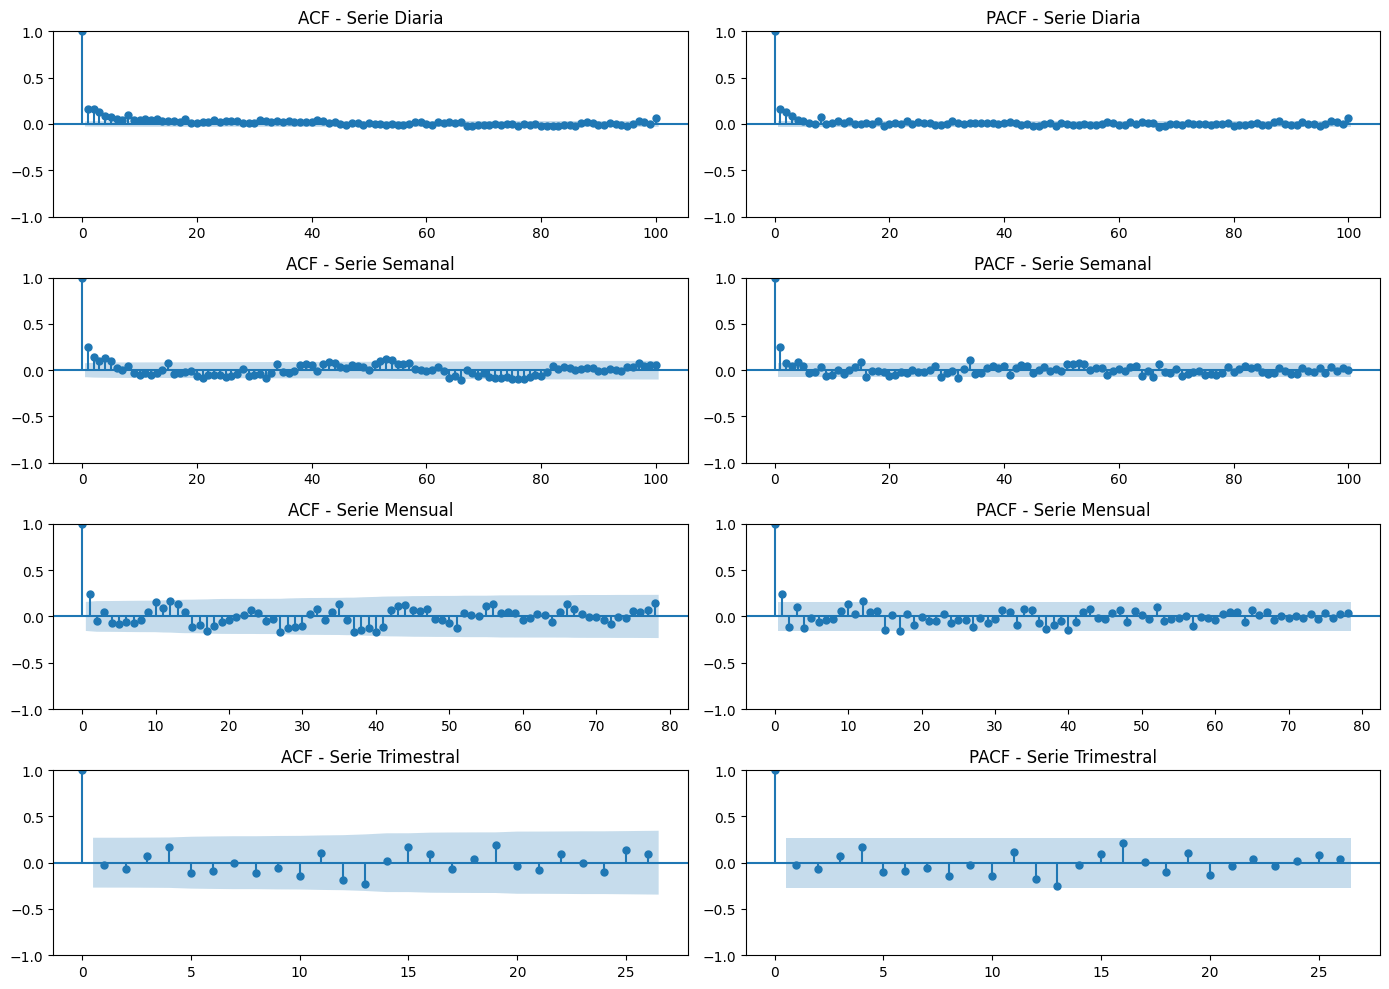

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Crear figura con subplots para PACF
fig, axes = plt.subplots(4, 2, figsize=(14, 10))

# Definir títulos y datos
series = [daily_serie, weekly_serie, monthly_serie, quarterly_serie]
titles = ["Serie Diaria", "Serie Semanal", "Serie Mensual", "Serie Trimestral"]

for i, (data, title) in enumerate(zip(series, titles)):
    lags = min(100, len(data.dropna()) // 2)  # Ajuste dinámico de rezagos
    if lags > 0:
        plot_acf(data.dropna(), ax=axes[i, 0], lags=lags)
        plot_pacf(data.dropna(), ax=axes[i, 1], method='ywm', lags=lags)
    axes[i, 0].set_title(f"ACF - {title}")
    axes[i, 1].set_title(f"PACF - {title}")

fig.savefig("acf_pacf_figure.svg", format="svg")
plt.tight_layout()
plt.show()


- En esta grafica podremos interactuar con cualquiera de las anteriores, se realiza este paso para poder analizar a detalle cada serie, en el proceso exploratorio.

### Analisis de estacionaridad
---
Una serie es estacionaria si su media y varianza son constantes en el tiempo y no muestra una tendencia creciente o decreciente.
A continuacion se despliegan una serie de pruebas para determinar si la serie es estacionaria.

**✅ Pruebas estadísticas para Estacionariedad**
1. Prueba de Dickey-Fuller Aumentada (ADF)

**Objetivo:** Determinar si la serie tiene una raíz unitaria (lo que indica no estacionariedad).

- Hipótesis Nula (H₀): La serie tiene una raíz unitaria (NO es estacionaria).
- Hipótesis Alternativa (H₁): La serie es estacionaria.
- Si p-valor < 0.05, rechazamos H₀ → La serie es estacionaria.

In [38]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf, pacf

# Definir series y títulos
series = [daily_serie, weekly_serie, monthly_serie, quarterly_serie]
titles = ["Serie Diaria", "Serie Semanal", "Serie Mensual", "Serie Trimestral"]

fig = go.Figure()

for i, (data, title) in enumerate(zip(series, titles)):
    data_clean = data.dropna()
    lags = min(100, len(data_clean) // 2)  # Ajuste dinámico de rezagos
    if lags > 0:
        acf_values = acf(data_clean, nlags=lags)
        pacf_values = pacf(data_clean, nlags=lags, method='ywm')
        
        fig.add_trace(go.Bar(x=list(range(lags+1)), y=acf_values, name=f"ACF - {title}"))
        fig.add_trace(go.Bar(x=list(range(lags+1)), y=pacf_values, name=f"PACF - {title}"))

fig.update_layout(title="ACF y PACF de las Series de Tiempo", xaxis_title="Rezagos", yaxis_title="Valor", barmode='group')
fig.show()


2. Prueba KPSS (Kwiatkowski-Phillips-Schmidt-Shin)

**Objetivo:** Detectar si la serie es estacionaria en nivel o tendencia.

- Hipótesis Nula (H₀): La serie es estacionaria.
- Hipótesis Alternativa (H₁): La serie NO es estacionaria.
- Si p-valor < 0.05, rechazamos H₀ → La serie NO es estacionaria.

In [39]:

from statsmodels.tsa.stattools import adfuller

def test_stationarity(serie, name="Serie"):
    serie = serie.dropna()  # Eliminar NaN
    if len(serie) < 10:  # Mínimo requerido para ADF
        print(f"⚠️ {name}: La serie es muy corta para ADF.")
        return
    
    result = adfuller(serie)
    
    print(f"\n🔍 **Prueba ADF para {name}**")
    print("Estadístico de Prueba ADF:", result[0])
    print("P-valor:", result[1])
    print("Valores Críticos:", result[4])
    
    if result[1] < 0.05:
        print("✅ La serie es estacionaria")
    else:
        print("❌ La serie NO es estacionaria (podría requerir diferenciación)")
        
        # Aplicar diferenciación
        diff_serie = serie.diff().dropna()
        result_diff = adfuller(diff_serie)
        
        print("\n📉 **Prueba ADF tras una diferenciación**")
        print("Estadístico de Prueba ADF:", result_diff[0])
        print("P-valor:", result_diff[1])
        if result_diff[1] < 0.05:
            print("✅ Tras una diferenciación, la serie es estacionaria")
        else:
            print("❌ La serie sigue sin ser estacionaria, podría requerir una segunda diferenciación")

# Aplicar prueba ADF a múltiples series
for i, serie in enumerate(series):
    test_stationarity(serie, name=f"Serie {i+1}")



🔍 **Prueba ADF para Serie 1**
Estadístico de Prueba ADF: -19.228852011591638
P-valor: 0.0
Valores Críticos: {'1%': np.float64(-3.4317113808065844), '5%': np.float64(-2.86214157776022), '10%': np.float64(-2.5670902214893334)}
✅ La serie es estacionaria

🔍 **Prueba ADF para Serie 2**
Estadístico de Prueba ADF: -10.004452592927976
P-valor: 1.847265755774431e-17
Valores Críticos: {'1%': np.float64(-3.4401478069875613), '5%': np.float64(-2.8658634456698464), '10%': np.float64(-2.5690723769213633)}
✅ La serie es estacionaria

🔍 **Prueba ADF para Serie 3**
Estadístico de Prueba ADF: -8.447780741550874
P-valor: 1.6943475715611548e-13
Valores Críticos: {'1%': np.float64(-3.473542528196209), '5%': np.float64(-2.880497674144038), '10%': np.float64(-2.576878053634677)}
✅ La serie es estacionaria

🔍 **Prueba ADF para Serie 4**
Estadístico de Prueba ADF: -7.221290868896415
P-valor: 2.1080571903305081e-10
Valores Críticos: {'1%': np.float64(-3.562878534649522), '5%': np.float64(-2.918973284023669), 

In [40]:
from statsmodels.tsa.stattools import kpss

def test_kpss(serie, name="Serie"):
    serie = serie.dropna()  # Eliminar NaN
    if len(serie) < 10:  # Mínimo requerido para KPSS
        print(f"⚠️ {name}: La serie es muy corta para KPSS.")
        return
    
    result = kpss(serie, regression='c', nlags="auto")  # 'c' = tendencia constante
    
    print(f"\n🔍 **Prueba KPSS para {name}**")
    print("Estadístico de Prueba KPSS:", result[0])
    print("P-valor:", result[1])
    print("Valores Críticos:", result[3])
    
    if result[1] < 0.05:
        print("❌ La serie NO es estacionaria según KPSS (tiene tendencia)")
    else:
        print("✅ La serie es estacionaria según KPSS")

# Aplicar prueba KPSS a múltiples series
for i, serie in enumerate(series):
    test_kpss(serie, name=f"Serie {i+1}")



🔍 **Prueba KPSS para Serie 1**
Estadístico de Prueba KPSS: 0.09392172924916538
P-valor: 0.1
Valores Críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
✅ La serie es estacionaria según KPSS

🔍 **Prueba KPSS para Serie 2**
Estadístico de Prueba KPSS: 0.06826695669248023
P-valor: 0.1
Valores Críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
✅ La serie es estacionaria según KPSS

🔍 **Prueba KPSS para Serie 3**
Estadístico de Prueba KPSS: 0.08235152505205617
P-valor: 0.1
Valores Críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
✅ La serie es estacionaria según KPSS

🔍 **Prueba KPSS para Serie 4**
Estadístico de Prueba KPSS: 0.1067247715103732
P-valor: 0.1
Valores Críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
✅ La serie es estacionaria según KPSS


C:\Users\dreng\AppData\Local\Temp\ipykernel_23312\3022081907.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\dreng\AppData\Local\Temp\ipykernel_23312\3022081907.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\dreng\AppData\Local\Temp\ipykernel_23312\3022081907.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\dreng\AppData\Local\Temp\ipykernel_23312\3022081907.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




### Analisis de Estacionalidad
---
La estacionalidad ocurre cuando hay patrones repetitivos en intervalos regulares.

**✅ Pruebas estadísticas para Estacionalidad**

1. Prueba de Friedman

Evalúa si los valores de la serie cambian sistemáticamente a lo largo del tiempo.


In [41]:
from scipy.stats import friedmanchisquare
import numpy as np

def test_friedman(serie):
    n_periodos = 12  # Por ejemplo, mensual
    grupos = [serie[i::n_periodos] for i in range(n_periodos)]
    stat, p = friedmanchisquare(*grupos)
    print("Estadístico de Prueba Friedman:", stat)
    print("P-valor:", p)

    if p < 0.05:
        print("✅ La serie tiene estacionalidad")
    else:
        print("❌ No hay evidencia de estacionalidad")

for serie in series:
    test_friedman(serie)


ValueError: Array shapes are incompatible for broadcasting.

2. Prueba de Kruskal-Wallis

prueba no paramétrica que evalúa diferencias entre períodos.

In [ ]:
from scipy.stats import kruskal

def test_kruskal(serie):
    n_periodos = 12
    grupos = [serie[i::n_periodos] for i in range(n_periodos)]
    stat, p = kruskal(*grupos)
    print("Estadístico de Prueba Kruskal-Wallis:", stat)
    print("P-valor:", p)

    if p < 0.05:
        print("✅ La serie tiene estacionalidad")
    else:
        print("❌ No hay evidencia de estacionalidad")

for serie in series:
    test_kruskal(serie)


Estadístico de Prueba Kruskal-Wallis: nan
P-valor: nan
❌ No hay evidencia de estacionalidad
Estadístico de Prueba Kruskal-Wallis: nan
P-valor: nan
❌ No hay evidencia de estacionalidad
Estadístico de Prueba Kruskal-Wallis: nan
P-valor: nan
❌ No hay evidencia de estacionalidad
Estadístico de Prueba Kruskal-Wallis: nan
P-valor: nan
❌ No hay evidencia de estacionalidad


### Visualización de Estacionariedad y Estacionalidad
---
✅ Gráfico de Tendencia y Estacionalidad con STL

El método STL (Seasonal-Trend Decomposition) descompone la serie en:

1. Tendencia
2. Estacionalidad
3. Residuo (ruido aleatorio)

In [ ]:
from statistics_utils.eda.timeseries import decompose_time_series

descompose=decompose_time_series(dataset.iloc[:,0])
descompose

Frecuencia inferida: W-SUN
Frecuencia 'W-SUN' no soportada para conversión.


| Tipo             | Pruebas                | Conclusión                                              |
|-----------------|------------------------|---------------------------------------------------------|
| Estacionariedad | ADF, KPSS               | Si no es estacionaria, aplicar diferenciación (d) en ARIMA |
| Estacionalidad  | Friedman, Kruskal-Wallis, STL | Si hay estacionalidad, usar SARIMA en vez de ARIMA     |



En este analisis crearemos una rutina para la descripcion, descomposicion y analisiz a profundidad de las series de tiempo de la red mpomm alojadas en la base de datos oficial.

## Analisis estadistico

- Analisis descriptivo